In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax import jit, random, vmap
import re

In [3]:
import examples.ice_melting_sphere.configs as cfg
from examples.ice_melting_sphere.model import PINN

cfg = cfg.Config()
pinn = PINN(config=cfg)
fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = [float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames]

In [4]:
import jax
import jax.numpy as jnp
from jax import vmap
import orbax.checkpoint as ocp
import examples.ice_melting_sphere.configs as cfg
from examples.ice_melting_sphere.model import PINN

ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/tf-logs/ice-melting/baseline/model-1000/")
params = state["params"]
cfg = cfg.Config()
pinn = PINN(config=cfg)

In [5]:
pred_radius = []
fem_radius = []
analytic_radius = []

mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::10] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()
    ref_sol = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.4f}.npy")[::10]
    def compute_radius(sol):
        interface_idx = jnp.where((sol > -0.5) & (sol < 0.5))[0]
        return jnp.mean(jnp.sqrt(
            mesh[interface_idx, 0]**2 
            + mesh[interface_idx, 1]**2 
            + mesh[interface_idx, 2]**2
        ) * cfg.Lc)
    pred_radius.append(compute_radius(pred))
    fem_radius.append(compute_radius(ref_sol))
    analytic_radius.append(cfg.R0 - cfg.LAMBDA * tic)

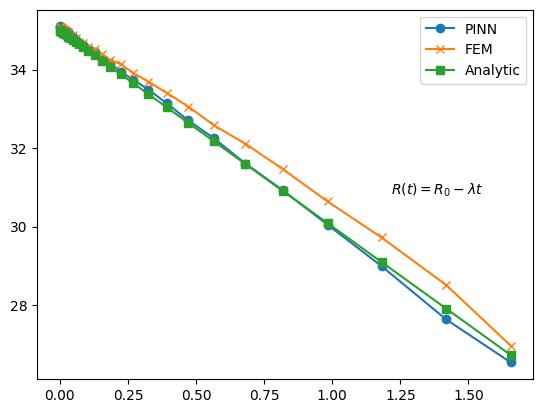

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(ts, pred_radius, label="PINN", marker="o")
ax.plot(ts, fem_radius, label="FEM", marker="x")
ax.plot(ts, analytic_radius, label="Analytic", marker="s")

# put the formulation of the analytic solution
ax.text(0.9, 0.5, r"$R(t) = R_0 - \lambda t$", transform=ax.transAxes, ha="right")

ax.legend()
